# Tuning policy hyper-parameters in JaxPlan

In this advanced notebook, we illustrate how to tune hyper-parameters of the policy and planner efficiently using Bayesian optimization, such as the topology of the policy network, the learning rate, and the model relaxations.

Start by installing the required packages. Notice we use the ``extra`` argument to install the required ``bayesian-optimization`` package:

In [1]:
%pip install --quiet --upgrade pip
%pip install --quiet pandas pyRDDLGym rddlrepository pyRDDLGym-jax[extra]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the required packages:

In [2]:
import os
import pandas as pd
from IPython.display import Image
from IPython.utils import io
import matplotlib.pyplot as plt
import math

import pyRDDLGym
from pyRDDLGym.core.visualizer.movie import MovieGenerator
from pyRDDLGym_jax.core.planner import JaxBackpropPlanner, JaxOfflineController, load_config_from_string
from pyRDDLGym_jax.core.tuning import JaxParameterTuning, Hyperparameter

C:\Python\envs\rddl\Lib\site-packages\pyRDDLGym\core\debug\exception.py:28: UserWarning: cv2 is not installed: save_as_mp4 option will be disabled.
  warnings.warn(message)


We will use the MountainCar control problem as our example:

In [3]:
env = pyRDDLGym.make('MountainCar_Continuous_gym', '0', vectorized=True)

In order to instruct the tuner to tune specific parameters, we need to create a config file with placeholders for the tunable parameters. In this case, we let TUNE_LR denote the learning rate, TUNE_L1 and TUNE_L2 denote the layer sizes of the policy, and TUNE_WEIGHT to denote the model relaxation parameter:

In [4]:
config = """
[Model]
comparison_kwargs={'weight': TUNE_WEIGHT}
rounding_kwargs={'weight': TUNE_WEIGHT}
control_kwargs={'weight': TUNE_WEIGHT}
[Optimizer]
method='JaxDeepReactivePolicy'
method_kwargs={'topology': [TUNE_L1, TUNE_L2]}
optimizer_kwargs={'learning_rate': TUNE_LR}
batch_size_train=1
batch_size_test=1
[Training]
train_seconds=15
print_summary=False
print_progress=False
"""

Next, we need to connect the selected hyperparameters to ranges the Bayesian optimizer searches over, as well as a mapping from the BO parameter to the RDDL equivalent:

In [5]:
hyperparams = [
    Hyperparameter('TUNE_WEIGHT', 0., 15., math.exp2),
    Hyperparameter('TUNE_LR', -15., 0., math.exp2),
    Hyperparameter('TUNE_L1', 2, 64, math.floor),
    Hyperparameter('TUNE_L2', 2, 64, math.floor)
]    

Next, we will instantiate the tuning instance for the policy network (DRP). This will tune the topology of the network, learning rate and model hyper-parameters. We specify number of independent runs to average per trial, number of parallel threads to 4, and number of iterations to 10, leading to a total of 40 individual trials/hyper-parameters to test: 

In [6]:
tuning = JaxParameterTuning(env=env, config_template=config, hyperparams=hyperparams, online=False,
                            eval_trials=1, num_workers=4, gp_iters=10)

Finally, we launch the tuning instance, where we specify the RNG key, the file where logs will be saved, and that we wish to save a plot of the hyper-parameters tried in a 2D space. Warning: this will take a while:

In [7]:
with io.capture_output():
    best_params = tuning.tune(key=42, log_file='mountaincar_tuning.csv')
print(best_params)

{'TUNE_WEIGHT': 10.104708040704434, 'TUNE_LR': 0.00035041832766298753, 'TUNE_L1': 61, 'TUNE_L2': 12}


The outputs of the bayesian optimization have now been saved in a csv file. Let's use pandas to read this file:

In [8]:
gp_data = pd.read_csv('mountaincar_tuning.csv')
gp_data.head(5)

,pid,worker,iteration,target,best_target,acq_params,TUNE_WEIGHT,TUNE_LR,TUNE_L1,TUNE_L2
0,31252,0,0,-20.000000,91.871464,{'random_state': RandomState(MT19937) at 0x233...,504.908188,0.061636,25,60
1,19792,1,0,-0.000060,91.871464,{'random_state': RandomState(MT19937) at 0x233...,8150.326768,0.000056,11,11
2,30408,2,0,-0.000059,91.871464,{'random_state': RandomState(MT19937) at 0x233...,23965.107358,0.000038,39,45
3,28576,3,0,91.871464,91.871464,{'random_state': RandomState(MT19937) at 0x233...,6.732152,0.000202,53,15
4,13564,0,1,88.120588,91.871464,{'random_state': RandomState(MT19937) at 0x233...,7.676418,0.001000,62,11


Let's plot the target values across iterations:

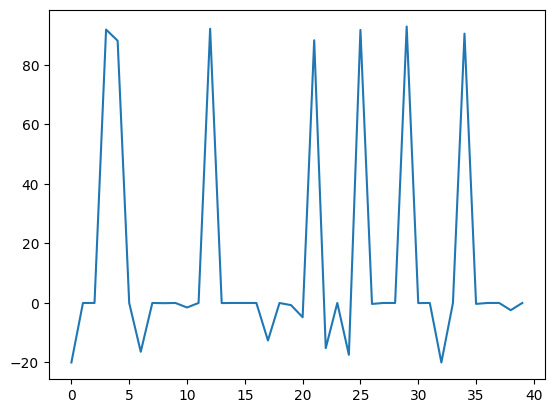

In [9]:
%matplotlib inline
plt.plot(gp_data['target'])
plt.show()

The config file corresponding to the best hyper-parameters is:

In [10]:
print(tuning.best_config)


[Model]
comparison_kwargs={'weight': 10.104708040704434}
rounding_kwargs={'weight': 10.104708040704434}
control_kwargs={'weight': 10.104708040704434}
[Optimizer]
method='JaxDeepReactivePolicy'
method_kwargs={'topology': [61, 12]}
optimizer_kwargs={'learning_rate': 0.00035041832766298753}
batch_size_train=1
batch_size_test=1
[Training]
train_seconds=15
print_summary=False
print_progress=False



Let's load this config into a planner and evaluate it:

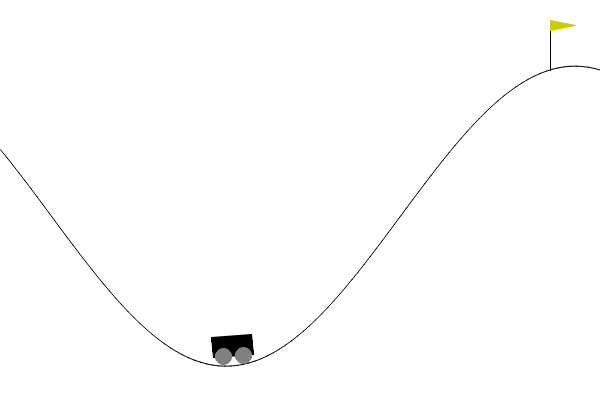

In [11]:
planner_args, _, train_args = load_config_from_string(tuning.best_config)
planner = JaxBackpropPlanner(rddl=env.model, **planner_args)
agent = JaxOfflineController(planner, **train_args)

if not os.path.exists('frames'):
    os.makedirs('frames')
recorder = MovieGenerator("frames", "mountaincar", max_frames=env.horizon)
env.set_visualizer(viz=None, movie_gen=recorder)
agent.evaluate(env, episodes=1, render=True)
env.close()
Image(filename='frames/mountaincar_0.gif') 